In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns
from adjustText import adjust_text
from matplotlib import gridspec
%matplotlib inline

## Mixture Proportion Bar Plot

In [ ]:
fig = plt.figure(figsize=(18,8))

x = np.arange(0,len(df.mix_0.unique()))
for i in range(1,10):
    plt.scatter(x,df["mix_{0}".format(i)], color="purple", s=10, alpha = 0.5)
plt.bar(x,df_ave, alpha=1, color="None", edgecolor="royalblue")
plt.errorbar(x,df_ave,yerr=df_std,linestyle="none",label="stdev", color="royalblue",alpha= 0.5,elinewidth=1)

plt.xticks(x, df.mix_0.unique(), rotation = 'vertical', fontsize='xx-large')
plt.yticks(fontsize='x-large')
plt.xlabel('Variance-Covariance Matrice', fontsize='x-large')
plt.ylabel('Proportion', fontsize='x-large')
plt.legend()
plt.title('Mixture Proportions for Different Covariance Matrices - {0}'.format(pheno), fontsize="xx-large")

#plt.tight_layout()
#plt.savefig("{0}mixpropbar.png".format(pheno))

## Heatmap

In [ ]:
# load in mixture proportion results as dataframe
pheno = "testosterone"
os.chdir('C:\\Users\\Carrie Zhu\\Documents\\Research\\GWAS-frontera\\GWAS_Results\\{0}'.format(pheno))
df = pd.read_csv("{0}mixprop_12_5e-2.txt".format(pheno),sep="\t")

In [ ]:
# get mean and std error; split matrice name into correlation and effect categories
df_values = pd.DataFrame({'sem':(df.std(axis=1)/np.sqrt(len(df.columns)-1)),'ave':df.mean(axis=1)})
df = pd.concat([df['mix_0'], df_values['ave'], df_values['sem']], axis=1)
split_df = df["mix_0"].str.split("_", n=2, expand = True)
df['corr'] = split_df[1].astype(float)
df['effect'] = split_df[0] + split_df[2]

In [ ]:
# create pivot table to hypothesis and null matrices for averages and sem
df_hyp = df.loc[pd.notnull(df['effect'])]
df_ave = df_hyp.pivot(index='corr',columns='effect',values='ave')
df_ave = df_ave.reindex(columns=['f1','f3', 'f2', 'f1.5','equal1','m1.5','m2','m3','m1'])
df_ave = df_ave.sort_values('corr', ascending=False)

df_sem = df_hyp.pivot(index='corr',columns='effect',values='sem')
df_sem = df_sem.reindex(columns=['f1','f3', 'f2', 'f1.5','equal1','m1.5','m2','m3','m1'])
df_sem = df_sem.sort_values('corr', ascending=False)

df_null = df.loc[pd.isnull(df['effect'])]
df_null_ave = pd.DataFrame(list(df_null['ave']), index=list(df_null['mix_0']), columns=['Average']).T
df_null_sem = pd.DataFrame(list(df_null['sem']), index=list(df_null['mix_0']), columns=['SEM']).T

In [ ]:
# plot heat map
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(8, 12)
ax1 = fig.add_subplot(gs[0:6,:])
ax2 = fig.add_subplot(gs[6:7,1:6])

plt.suptitle("Hypothesis Matrices with Weights - {0}".format(pheno.upper()), fontsize='x-large')
sns.heatmap(df_ave, cmap='BuGn', annot=True, annot_kws={'size':14, 'va':'bottom'}, linewidths=1, ax=ax1, fmt='.2f')
sns.heatmap(df_ave, cmap='BuGn', annot=df_sem, annot_kws={'size':8, 'va':'top'}, linewidths=1, ax=ax1, fmt='.2f',cbar=False)

ax1.xaxis.tick_top()
ax1.xaxis.set_label_position('top')
ax1.set_xlabel('Magnitude',fontsize='large', labelpad=15)
ax1.set_ylabel('Correlation', fontsize='large', labelpad=15)
ax1.tick_params(labelsize=12, labelrotation=0.5)

ax2.set_title("Data-Driven and Null Matrices")
sns.heatmap(df_null_ave, cmap='BuGn', annot=True, annot_kws={'size':14, 'va':'bottom'}, linewidths=1, ax=ax2, cbar=False, fmt='.2f')
sns.heatmap(df_null_ave, cmap='BuGn', annot=df_null_sem, annot_kws={'size':8, 'va':'top'}, linewidths=1, ax=ax2, cbar=False, fmt='.2f')
ax2.tick_params(labelsize=12, labelrotation=0.5)

plt.tick_params(labelsize=12)

plt.tight_layout()
#plt.savefig("{0}mixheat_all.pdf".format(pheno))

#### Simplified Heat Map

In [ ]:
# create simplied table, proportion based on non-null
nan_weight = 1 / (1 - df_null.iloc[0]['ave'])
df_s = df_ave * nan_weight
f = df_s.filter(regex='f').sum(axis=1)
equal = df_s.filter(regex='equal').sum(axis=1)
m = df_s.filter(regex='m').sum(axis=1)
df_s = pd.DataFrame([f,equal,m], index=['F > M','F = M','F < M']).T
perfect = df_s.loc[df_s.index.astype(float) == 1].sum()
partial = df_s.loc[(df_s.index.astype(float) > 0) & (df_s.index.astype(float) < 1)].sum()
uncorrelated = df_s.loc[df_s.index.astype(float) == 0].sum()
negative = df_s.loc[df_s.index.astype(float) < 0].sum()
df_s = pd.DataFrame([perfect,partial,uncorrelated,negative], index=['perfect','partial','uncorrelated','negative'])

gender_sum = ['%.0f' % i for i in 100*round(df_s.sum(),2)]
gender_sum = pd.DataFrame(gender_sum).T
corr_sum = ['%.0f' % i for i in 100*round(df_s.sum(axis=1),2)]
corr_sum = pd.DataFrame(corr_sum)
print(df_s)

In [ ]:
# create simplified heat map 
fig, ax = plt.subplots(figsize=(9, 5))
sns.heatmap(df_s, cmap='BuGn', annot=True, annot_kws={'size':14}, linewidths=5, fmt='.0%', xticklabels=True, yticklabels=False)

ax.xaxis.tick_top()
ax.tick_params(axis='x', top=False, pad=30, labelsize='13')
ax.xaxis.set_label_position('top')
#ax.set_xlabel('Magnitude',fontsize='18', labelpad=20)
#ax.set_ylabel('Correlation', fontsize='18', labelpad=25)
#ax.tick_params(labelsize=15, labelrotation=0.5)

tbl1 = ax.table(cellText=gender_sum.values+'%', cellLoc='center',
                bbox=[0.005,1.01,0.99,.1])
tbl2 = ax.table(cellText=corr_sum.values+'%', rowLabels=['Perfect','Partial, Positive','Uncorrelated','Negative'], rowLoc='right',
                cellLoc='center', bbox=[-0.26,0.01,.13,0.98])
tbl1.auto_set_font_size(False)
tbl2.auto_set_font_size(False)
tbl2.auto_set_column_width(False)
for i in range(4):
    tbl2.get_celld()[(i,0)].set_text_props(fontfamily='Arial', fontsize='13')
    tbl2.get_celld()[(i,0)].set_linewidth(0.5)
    tbl2.get_celld()[(i,-1)].set_text_props(fontfamily='Arial', fontsize='13')
    tbl2.get_celld()[(i,-1)].visible_edges = ''
for c in tbl1.get_celld().values():
    c.set_text_props(fontfamily='Arial', fontsize='13')
    c.set_linewidth(0.5)
ax.text(-1.08,-0.13,'Correlation',fontdict={'size':'large', 'style':'italic'})
ax.text(-0.55,-0.55,'Magnitude',fontdict={'size':'large', 'style':'italic'})
plt.suptitle("Mixture Proportions for {0}".format(pheno.capitalize()), fontsize='x-large', x=0.55)
plt.annotate("",xy=(0,0),xytext=(-1,-0.75),color='black', arrowprops={'arrowstyle':'-'})

plt.tight_layout()
plt.savefig("{0}mixheat_small.pdf".format(pheno))

## P-value Thresholds

In [100]:
pheno = "testosterone"
pvalues = ["all","1e-3","5e-2","1e-5","1e-6","5e-8"]

In [101]:
df_gender = pd.DataFrame()
df_corr = pd.DataFrame()
df_nulls = pd.DataFrame()

for p in pvalues:
    # load in dataframes
    os.chdir('C:\\Users\\Carrie Zhu\\Documents\\Research\\GWAS-frontera\\GWAS_Results\\{0}'.format(pheno))
    df = pd.read_csv("{0}mixprop_12_{1}.txt".format(pheno, p),sep="\t")

    # get mean and sem; split matrice name into correlation and effect categories
    df_values = pd.DataFrame({'sem':(df.std(axis=1)/np.sqrt(len(df.columns)-1)),'ave':df.mean(axis=1)})
    df = pd.concat([df['mix_0'], df_values['ave'], df_values['sem']], axis=1)
    split_df = df["mix_0"].str.split("_", n=2, expand = True)
    df['corr'] = split_df[1].astype(float)
    df['effect'] = split_df[0] + split_df[2]

    # create pivot table to hypothesis and null matrices for averages and sem
    df_hyp = df.loc[pd.notnull(df['effect'])]
    df_ave = df_hyp.pivot(index='corr',columns='effect',values='ave')
    df_ave = df_ave.reindex(columns=['f1','f3', 'f2', 'f1.5','equal1','m1.5','m2','m3','m1'])
    df_ave = df_ave.sort_values('corr', ascending=False)

    df_sem = df_hyp.pivot(index='corr',columns='effect',values='sem')
    df_sem = df_sem.reindex(columns=['f1','f3', 'f2', 'f1.5','equal1','m1.5','m2','m3','m1'])
    df_sem = df_sem.sort_values('corr', ascending=False)

    df_null = df.loc[pd.isnull(df['effect'])]
    df_null_ave = pd.DataFrame(list(df_null['ave']), index=list(df_null['mix_0']), columns=['Average']).T
    df_null_sem = pd.DataFrame(list(df_null['sem']), index=list(df_null['mix_0']), columns=['SEM']).T
    
    # create simplified heatmap, proportion of non-null
    nan_weight = 1 / (1 - df_null.iloc[0]['ave'])
    df_s = df_ave * nan_weight
    f = df_s.filter(regex='f').sum(axis=1)
    equal = df_s.filter(regex='equal').sum(axis=1)
    m = df_s.filter(regex='m').sum(axis=1)
    df_s = pd.DataFrame([f,equal,m], index=['F > M','F = M','F < M']).T
    perfect = df_s.loc[df_s.index.astype(float) == 1].sum()
    partial = df_s.loc[(df_s.index.astype(float) > 0) & (df_s.index.astype(float) < 1)].sum()
    uncorrelated = df_s.loc[df_s.index.astype(float) == 0].sum()
    negative = df_s.loc[df_s.index.astype(float) < 0].sum()
    df_s = pd.DataFrame([perfect,partial,uncorrelated,negative], index=['perfect','partial','uncorrelated','negative'])
    
    # get sum of gender and correlation for each p-value threshold
    df_gender = df_gender.append(df_s.sum(axis=0), ignore_index=True)
    df_corr = df_corr.append(df_s.sum(axis=1), ignore_index=True)
    df_nulls = df_nulls.append(df_null_ave, ignore_index=True)

#### non-null Matrice Weight

Text(0.5, 0.94, 'Change in Hypothesis Matrice Weight - TESTOSTERONE')

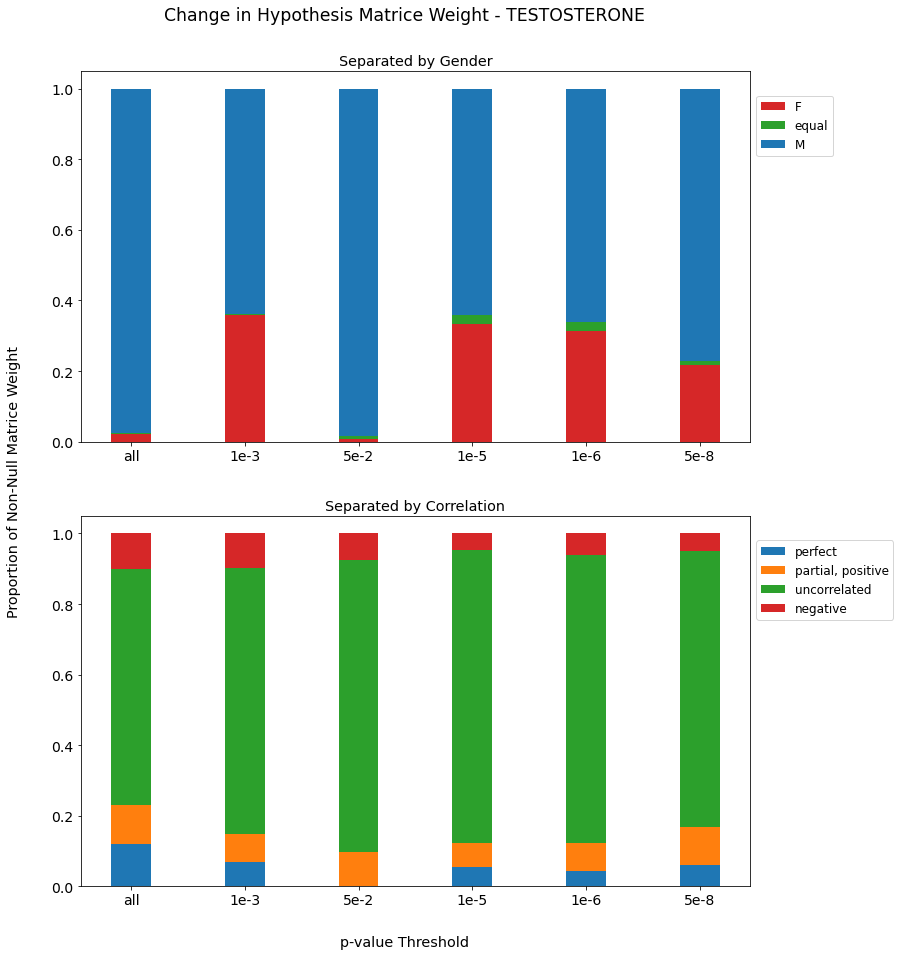

In [102]:
F = df_gender['F > M'].tolist()
equal = df_gender['F = M'].tolist()
M = df_gender['F < M'].tolist()
perfect = df_corr['perfect'].tolist()
partial = df_corr['partial'].tolist()
uncorrelated = df_corr['uncorrelated'].tolist()
negative = df_corr['negative'].tolist()
width=0.35

fig, axes = plt.subplots(2,1,figsize=(12, 15))
ax1 = axes[0]
ax2 = axes[1]

# gender
ax1.bar(pvalues, F, width, label='F', color='C3')
ax1.bar(pvalues, equal, width, bottom=F, label='equal', color='C2')
ax1.bar(pvalues, M, width, bottom=np.add(F,equal), label = 'M', color='C0')
ax1.tick_params(labelsize='14')
ax1.legend(prop={'size':12}, bbox_to_anchor=(1,0.95))
ax1.set_title('Separated by Gender', size='x-large')

# correlation
ax2.bar(pvalues, perfect, width, label = 'perfect')
ax2.bar(pvalues, partial, width, bottom=perfect, label = 'partial, positive')
ax2.bar(pvalues, uncorrelated, width, bottom=np.add(perfect,partial), label = 'uncorrelated')
ax2.bar(pvalues, negative, width, bottom=np.add(np.add(perfect,partial),uncorrelated), label = 'negative')
ax2.tick_params(labelsize='14')
ax2.legend(prop={'size':12}, bbox_to_anchor=(1,0.95))
ax2.set_title('Separated by Correlation', size='x-large')

fig.text(0.5, 0.07, 'p-value Threshold', ha='center', size='x-large')
fig.text(0.04, 0.5, 'Proportion of Non-Null Matrice Weight', va='center', rotation='vertical', size='x-large')
plt.suptitle('Change in Hypothesis Matrice Weight - {0}'.format(pheno.upper()), size='xx-large', y=0.94)

#plt.savefig("{0}_weight_by_pvalues.pdf".format(pheno))

#### null Matrice Weight

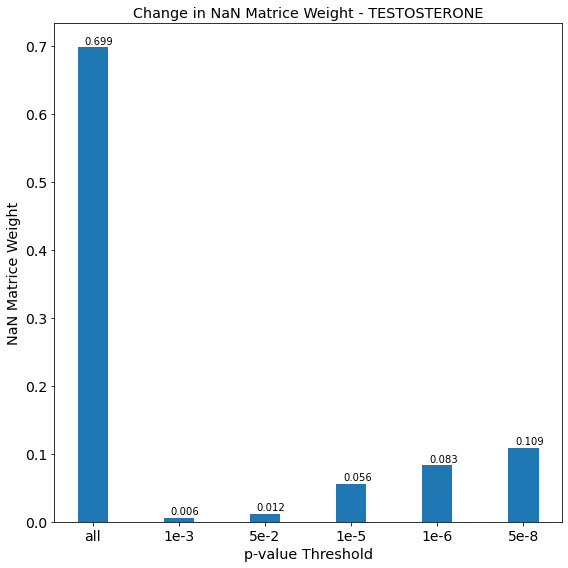

In [103]:
ave = np.squeeze(df_nulls.iloc[:,[0]].values)
fig, ax = plt.subplots(figsize=(8, 8))

bars = ax.bar(pvalues, ave, width)
ax.tick_params(labelsize='14')
ax.set_title('Change in NaN Matrice Weight - {0}'.format(pheno.upper()), size='x-large')
ax.set_xlabel('p-value Threshold', size='x-large')
ax.set_ylabel('NaN Matrice Weight', size='x-large')
for bar in bars:
    y = bar.get_height()
    plt.text(bar.get_x()+0.08, y+0.005, s=round(y,3))

plt.tight_layout()
#plt.savefig("{0}_nullweight_by_pvalues.pdf".format(pheno))